In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import json
import datetime
import time
import pandas as pd
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import csv

def load_csv(filename):
    lines = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

In [4]:
data = load_csv("/content/drive/My Drive/CS_4824/healthcare-dataset-stroke-data.csv")

In [5]:
print(len(data))
print(data[0])
print(len(data[0]))
print(data[0].keys())
print(data[0].values())
print(data[0]['age'])
print(data[0]['avg_glucose_level'])

5110
{'id': '9046', 'gender': 'Male', 'age': '67', 'hypertension': '0', 'heart_disease': '1', 'ever_married': 'Yes', 'work_type': 'Private', 'Residence_type': 'Urban', 'avg_glucose_level': '228.69', 'bmi': '36.6', 'smoking_status': 'formerly smoked', 'stroke': '1'}
12
dict_keys(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke'])
dict_values(['9046', 'Male', '67', '0', '1', 'Yes', 'Private', 'Urban', '228.69', '36.6', 'formerly smoked', '1'])
67
228.69


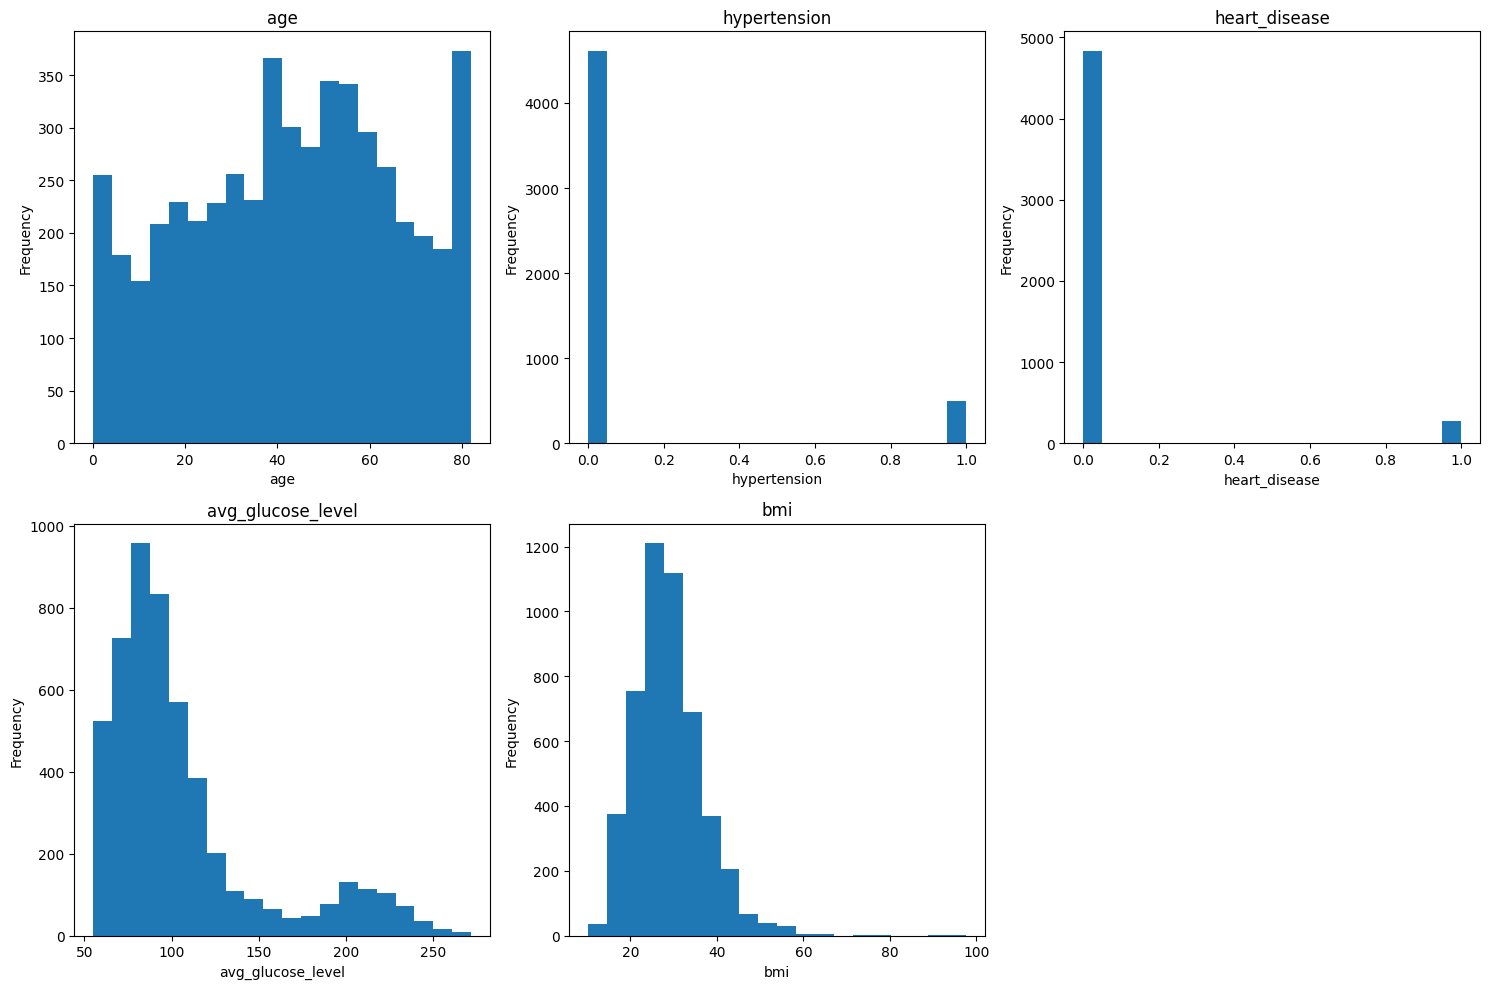

In [6]:
numerical_features = [key for key in data[0].keys() if key not in ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']]

num_plots = len(numerical_features)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    try:
        values = [float(item[feature]) for item in data if item[feature] != 'N/A']
        axes[i].hist(values, bins=20)
        axes[i].set_title(feature)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
    except (ValueError, TypeError):
        print(f"Skipping {feature} due to non-numeric or invalid values")
    except IndexError:
        pass

for j in range(i+1, len(axes)):
    axes[j].axis('off')


plt.tight_layout()
plt.show()

<ipython-input-7-65c8a354bcba>:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)
<ipython-input-7-65c8a354bcba>:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

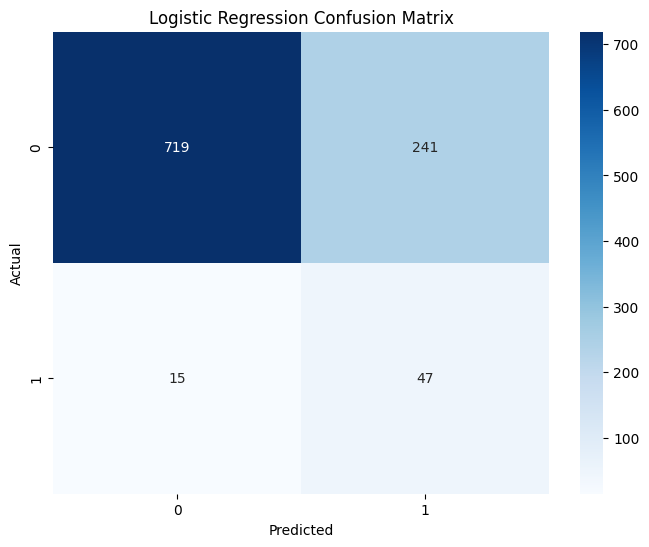

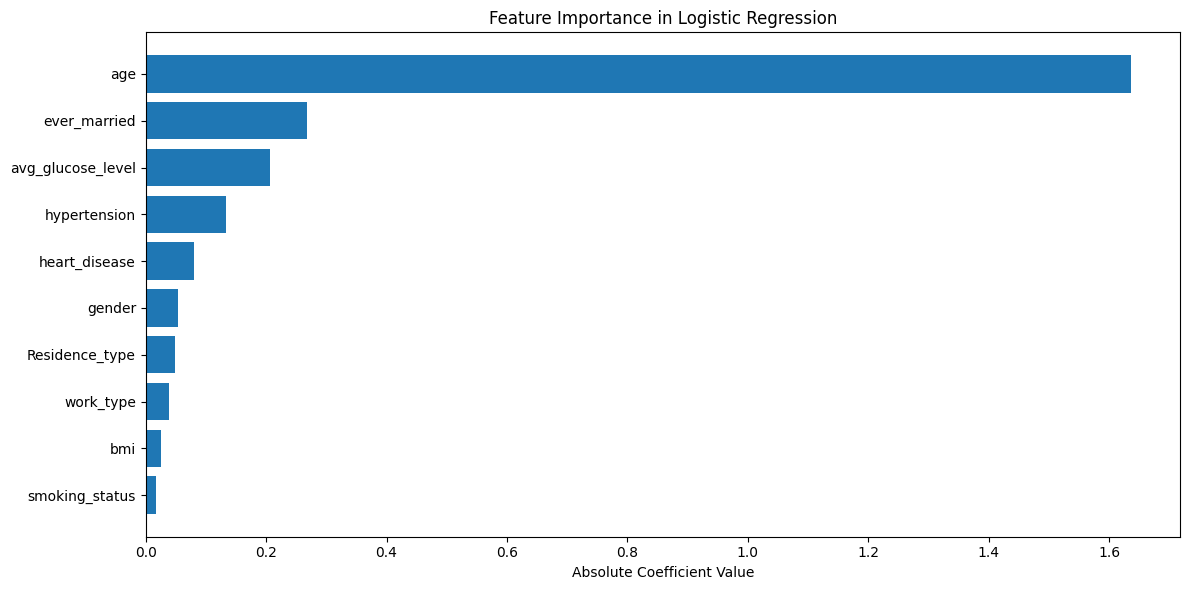

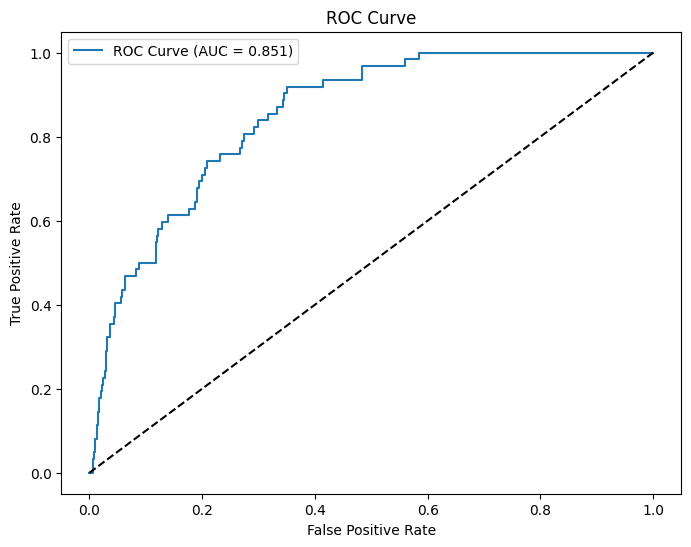


Logistic Regression Results:
Accuracy: 0.7495
Recall: 0.7581
Precision: 0.1632
AUC-ROC: 0.8506

Top 5 Most Important Features:
             feature  coefficient
1                age     1.636062
4       ever_married    -0.268064
7  avg_glucose_level     0.206595
2       hypertension     0.133189
3      heart_disease     0.079538


In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

class LogisticRegressionTracker:
    def __init__(self, base_dir='model_outputs'):
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        self.model_name = 'LogisticRegression'

        self.base_dir = Path(base_dir)
        self.run_dir = self.base_dir / f"{self.model_name}_{self.timestamp}"
        self.run_dir.mkdir(parents=True, exist_ok=True)

        self.metrics = {}
        self.feature_importance = {}

    def save_model(self, model):
        import pickle
        with open(self.run_dir / 'model.pkl', 'wb') as f:
            pickle.dump(model, f)

    def save_metrics(self):
        with open(self.run_dir / 'metrics.json', 'w') as f:
            json.dump(self.metrics, f, indent=4)

    def save_config(self, config):
        with open(self.run_dir / 'config.json', 'w') as f:
            json.dump(config, f, indent=4)

def plot_logistic_results(tracker, X_train, feature_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(tracker.metrics['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues')
    plt.title('Logistic Regression Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(tracker.run_dir / 'confusion_matrix.png')
    plt.show()

    plt.figure(figsize=(12, 6))
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(tracker.metrics['feature_coefficients'])
    }).sort_values('importance', ascending=True)

    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.title('Feature Importance in Logistic Regression')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.savefig(tracker.run_dir / 'feature_importance.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(tracker.metrics['fpr'], tracker.metrics['tpr'],
             label=f'ROC Curve (AUC = {tracker.metrics["auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig(tracker.run_dir / 'roc_curve.png')
    plt.show()

def prepare_data(df_path):
    df = pd.read_csv(df_path)

    df['bmi'].fillna(df['bmi'].mean(), inplace=True)
    df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)

    label_encoders = {}
    categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    X = df.drop(['stroke', 'id'], axis=1)
    y = df['stroke']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return X_train, X_test, y_train, y_test, label_encoders

def train_evaluate_logistic(X_train, X_test, y_train, y_test, config):
    tracker = LogisticRegressionTracker()

    tracker.save_config(config)

    model = LogisticRegression(**config['model_params'])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'feature_coefficients': model.coef_[0].tolist(),
        'feature_names': X_train.columns.tolist(),
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'auc': auc(fpr, tpr)
    }

    tracker.metrics.update(metrics)

    tracker.save_metrics()
    tracker.save_model(model)

    plot_logistic_results(tracker, X_train, X_train.columns)

    return tracker.metrics

config = {
    'model_params': {
        'max_iter': 10000,
        'class_weight': 'balanced',
        'random_state': 42
    },
    'data_preprocessing': {
        'test_size': 0.2,
        'random_state': 42
    }
}

X_train, X_test, y_train, y_test, label_encoders = prepare_data("/content/drive/My Drive/CS_4824/healthcare-dataset-stroke-data.csv")
metrics = train_evaluate_logistic(X_train, X_test, y_train, y_test, config)

print("\nLogistic Regression Results:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"AUC-ROC: {metrics['auc']:.4f}")

feature_importance = pd.DataFrame({
    'feature': metrics['feature_names'],
    'coefficient': metrics['feature_coefficients']
}).sort_values(by='coefficient', key=abs, ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

In [8]:
class DenseNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DenseNN, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.fc4(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool1d(2)

        conv_output_size = (input_size // 4) * 32

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [9]:
class ModelTracker:
    def __init__(self, model_name, base_dir='model_outputs'):
        self.timestamp = datetime.datetime.now()
        self.model_name = model_name

        self.base_dir = Path(base_dir)
        self.run_dir = self.base_dir / f"{model_name}_{self.timestamp}"
        self.run_dir.mkdir(parents=True, exist_ok=True)

        self.metrics = {
            'train_loss': [],
            'train_accuracy': [],
            'train_f1': [],
            'test_accuracy': [],
            'test_f1': [],
            'epoch_times': []
        }

    def update_metrics(self, epoch_metrics):
        for key, value in epoch_metrics.items():
            self.metrics[key].append(value)

    def save_model(self, model, optimizer):
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': self.metrics
        }
        torch.save(checkpoint, self.run_dir / 'model_checkpoint.pth')

    def save_metrics(self):
        with open(self.run_dir / 'metrics.json', 'w') as f:
            json.dump(self.metrics, f, indent=4)

    def save_config(self, config):
        with open(self.run_dir / 'config.json', 'w') as f:
            json.dump(config, f, indent=4)

def plot_metrics(tracker, save_dir):

    plt.figure(figsize=(10, 6))
    plt.plot(tracker.metrics['train_loss'], label='Training Loss')
    plt.title(f'{tracker.model_name} Training Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_dir / 'training_loss.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(tracker.metrics['train_accuracy'], label='Training Accuracy')
    plt.plot(tracker.metrics['test_accuracy'], label='Testing Accuracy')
    plt.plot(tracker.metrics['train_f1'], label='Training F1')
    plt.plot(tracker.metrics['test_f1'], label='Testing F1')
    plt.title(f'{tracker.model_name} Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.savefig(save_dir / 'metrics_comparison.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(tracker.metrics['final_confusion_matrix'],
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'{tracker.model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(save_dir / 'confusion_matrix.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    precision = tracker.metrics['precision_history'][-1]
    recall = tracker.metrics['recall_history'][-1]
    plt.scatter([recall], [precision], color='blue', s=100, label='Operating Point')
    plt.plot([0, 1], [precision, precision], '--', color='gray', label='Precision Line')
    plt.plot([recall, recall], [0, 1], '--', color='gray', label='Recall Line')
    plt.title(f'{tracker.model_name} Precision-Recall Point')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.savefig(save_dir / 'precision_recall.png')
    plt.show()

def train_evaluate_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                        config):
    from sklearn.metrics import f1_score, precision_recall_curve

    tracker = ModelTracker(model.__class__.__name__)
    tracker.save_config(config)

    class_counts = torch.bincount(y_train_tensor)
    total_samples = len(y_train_tensor)
    class_weights = total_samples / (2 * class_counts)
    class_weights = class_weights / class_weights.sum()

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    precision_history = []
    recall_history = []

    for epoch in range(config['num_epochs']):
        model.train()
        start_time = datetime.datetime.now()

        optimizer.zero_grad()
        train_outputs = model(X_train_tensor)
        loss = criterion(train_outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            train_preds = torch.argmax(train_outputs, dim=1)
            train_acc = accuracy_score(y_train_tensor, train_preds)
            train_f1 = f1_score(y_train_tensor, train_preds)

            test_outputs = model(X_test_tensor)
            test_preds = torch.argmax(test_outputs, dim=1)
            test_acc = accuracy_score(y_test_tensor, test_preds)
            test_f1 = f1_score(y_test_tensor, test_preds)

            current_precision = precision_score(y_test_tensor, test_preds)
            current_recall = recall_score(y_test_tensor, test_preds)
            precision_history.append(current_precision)
            recall_history.append(current_recall)

        epoch_metrics = {
            'train_loss': loss.item(),
            'train_accuracy': train_acc,
            'train_f1': train_f1,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'epoch_times': (datetime.datetime.now() - start_time).total_seconds()
        }
        tracker.update_metrics(epoch_metrics)

        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{config["num_epochs"]}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Train Acc: {train_acc:.4f}, '
                  f'Test Acc: {test_acc:.4f}, '
                  f'Train F1: {train_f1:.4f}, '
                  f'Test F1: {test_f1:.4f}')

    model.eval()
    with torch.no_grad():
        final_outputs = model(X_test_tensor)
        final_preds = torch.argmax(final_outputs, dim=1)

        final_metrics = {
            'accuracy': accuracy_score(y_test_tensor, final_preds),
            'recall': recall_score(y_test_tensor, final_preds),
            'precision': precision_score(y_test_tensor, final_preds),
            'f1_score': f1_score(y_test_tensor, final_preds),
            'final_confusion_matrix': confusion_matrix(y_test_tensor, final_preds).tolist(),
            'precision_history': precision_history,
            'recall_history': recall_history
        }

        tracker.metrics.update(final_metrics)
        tracker.save_metrics()
        tracker.save_model(model, optimizer)
        plot_metrics(tracker, tracker.run_dir)

        return tracker.metrics

def plot_model_comparison(cnn_metrics, dense_metrics, base_dir='model_outputs'):
    comparison_dir = Path(base_dir) / 'model_comparison'
    comparison_dir.mkdir(parents=True, exist_ok=True)

    metrics = ['accuracy', 'recall', 'precision', 'f1_score']
    values = {
        'CNN': [cnn_metrics[m] for m in metrics],
        'Dense NN': [dense_metrics[m] for m in metrics]
    }

    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))

    plt.bar(x - width/2, values['CNN'], width, label='CNN')
    plt.bar(x + width/2, values['Dense NN'], width, label='Dense NN')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.tight_layout()
    plt.savefig(comparison_dir / 'model_comparison.png')
    plt.show()

    comparison_results = {
        'CNN': cnn_metrics,
        'Dense NN': dense_metrics
    }
    with open(comparison_dir / 'comparison_results.json', 'w') as f:
        json.dump(comparison_results, f, indent=4)

<ipython-input-10-369650da31ab>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)
<ipython-input-10-369650da31ab>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin


Dataset Information:
Training samples: 4088
Testing samples: 1022
Number of features: 10
Class distribution in training set:
stroke
0    0.954256
1    0.045744
Name: proportion, dtype: float64

Training CNN Model
Epoch [2/400], Loss: 0.6636, Train Acc: 0.5499, Test Acc: 0.6928, Train F1: 0.1386, Test F1: 0.2379
Epoch [4/400], Loss: 0.6129, Train Acc: 0.8307, Test Acc: 0.4374, Train F1: 0.2046, Test F1: 0.1774
Epoch [6/400], Loss: 0.5630, Train Acc: 0.7502, Test Acc: 0.8297, Train F1: 0.2054, Test F1: 0.2750
Epoch [8/400], Loss: 0.5941, Train Acc: 0.8420, Test Acc: 0.7622, Train F1: 0.2083, Test F1: 0.2659
Epoch [10/400], Loss: 0.5541, Train Acc: 0.7013, Test Acc: 0.6252, Train F1: 0.1993, Test F1: 0.2294
Epoch [12/400], Loss: 0.5423, Train Acc: 0.6062, Test Acc: 0.6027, Train F1: 0.1710, Test F1: 0.2252
Epoch [14/400], Loss: 0.5175, Train Acc: 0.6421, Test Acc: 0.6526, Train F1: 0.1776, Test F1: 0.2333
Epoch [16/400], Loss: 0.5358, Train Acc: 0.6646, Test Acc: 0.6399, Train F1: 0.1834

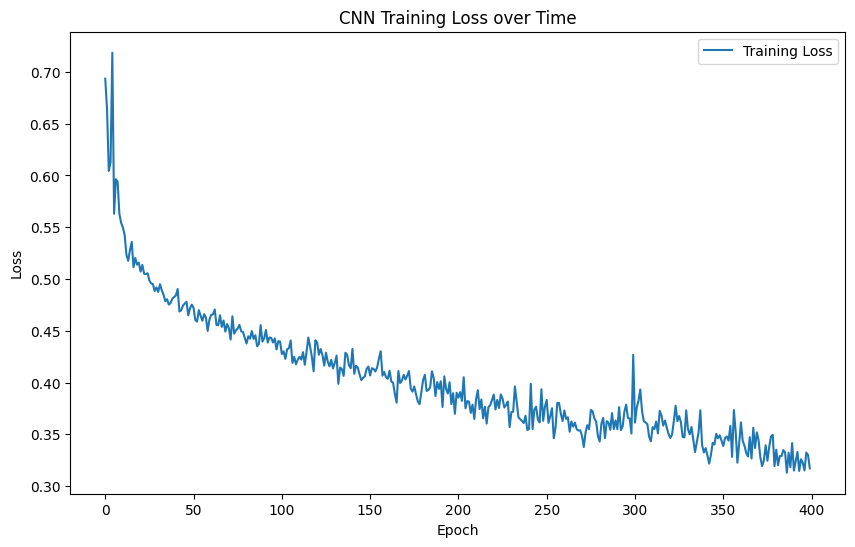

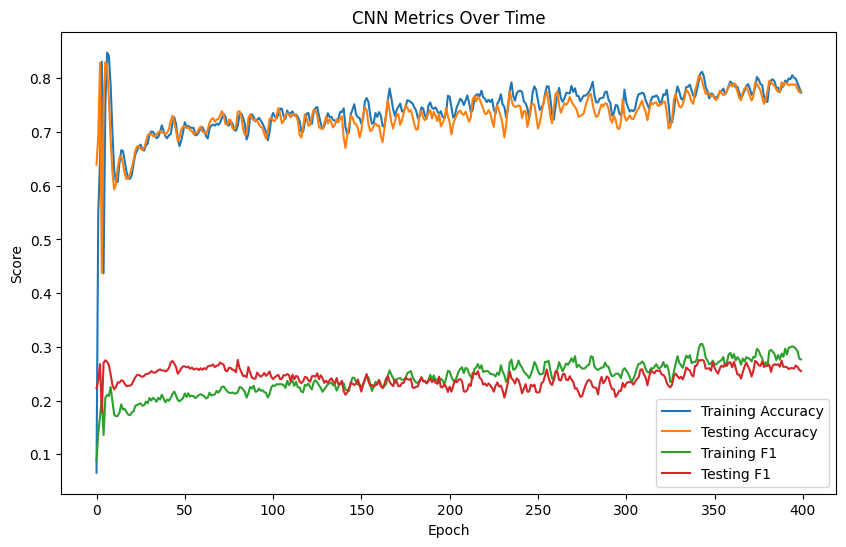

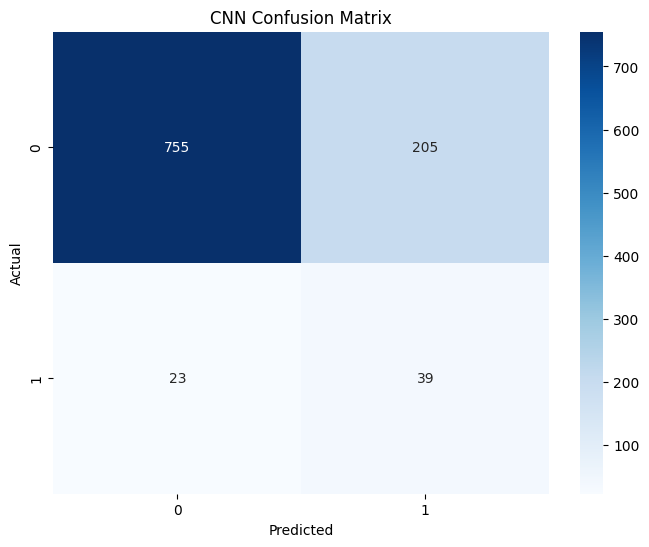

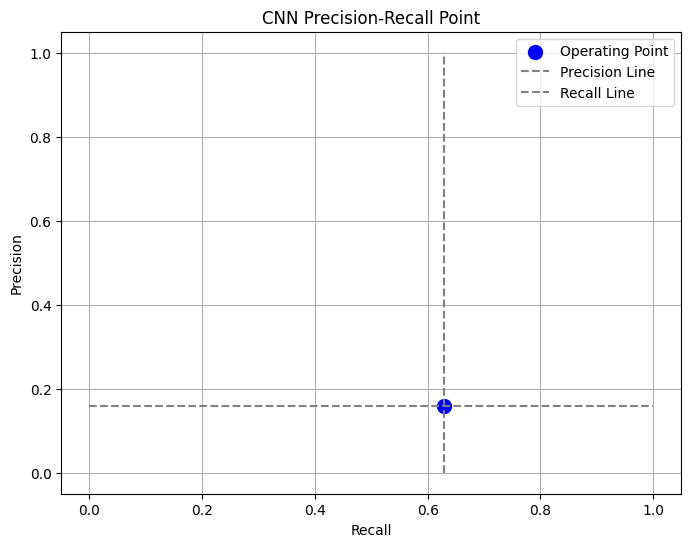

CNN Training Time: 63.25 seconds

Training Dense Neural Network
Epoch [2/400], Loss: 0.6031, Train Acc: 0.6644, Test Acc: 0.3278, Train F1: 0.1794, Test F1: 0.1529
Epoch [4/400], Loss: 0.5555, Train Acc: 0.6267, Test Acc: 0.5499, Train F1: 0.1787, Test F1: 0.2014
Epoch [6/400], Loss: 0.5314, Train Acc: 0.6495, Test Acc: 0.6233, Train F1: 0.1881, Test F1: 0.2254
Epoch [8/400], Loss: 0.5059, Train Acc: 0.6747, Test Acc: 0.6458, Train F1: 0.1910, Test F1: 0.2363
Epoch [10/400], Loss: 0.4851, Train Acc: 0.6898, Test Acc: 0.6614, Train F1: 0.2015, Test F1: 0.2412
Epoch [12/400], Loss: 0.4752, Train Acc: 0.6996, Test Acc: 0.6683, Train F1: 0.2118, Test F1: 0.2348
Epoch [14/400], Loss: 0.4692, Train Acc: 0.6942, Test Acc: 0.6781, Train F1: 0.2028, Test F1: 0.2367
Epoch [16/400], Loss: 0.4592, Train Acc: 0.6969, Test Acc: 0.6888, Train F1: 0.2093, Test F1: 0.2392
Epoch [18/400], Loss: 0.4552, Train Acc: 0.6984, Test Acc: 0.6986, Train F1: 0.2111, Test F1: 0.2451
Epoch [20/400], Loss: 0.4551, T

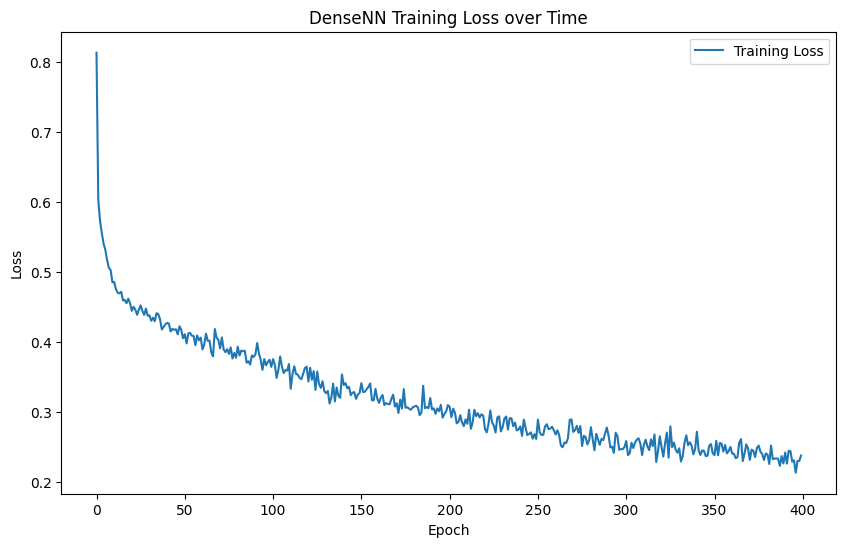

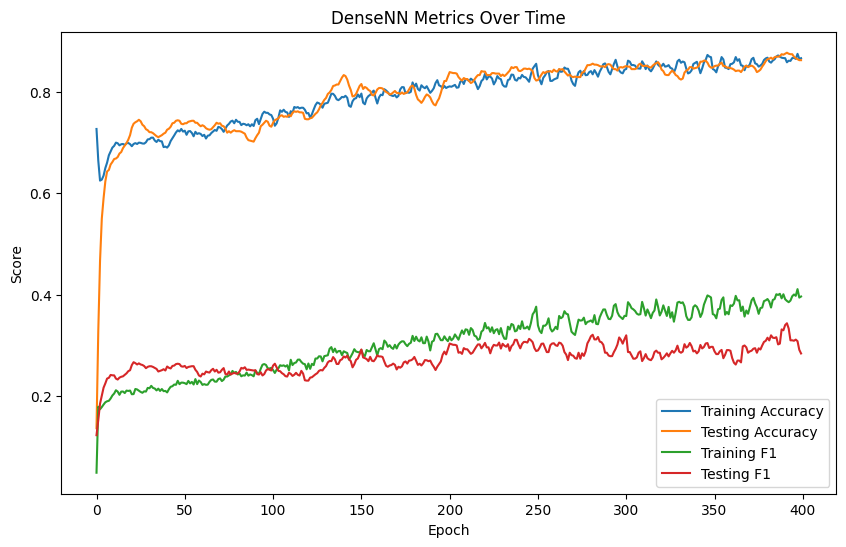

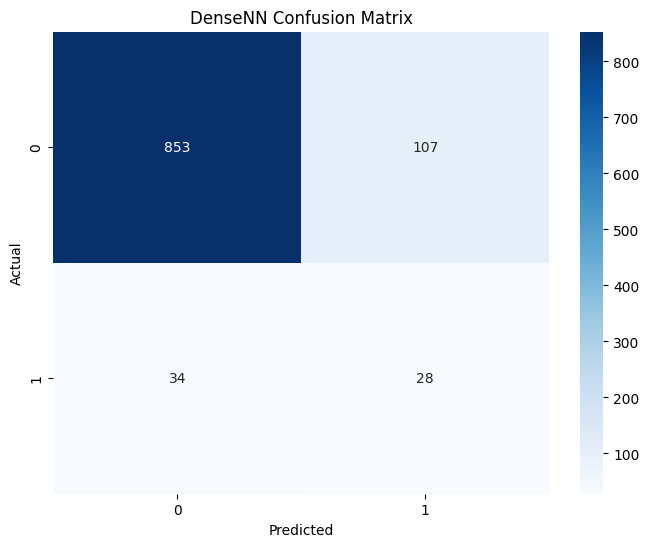

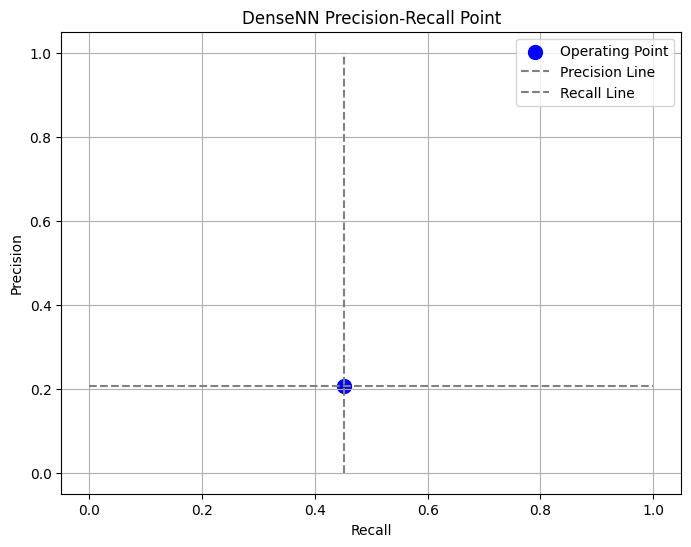

Dense Neural Network Training Time: 18.25 seconds

CNN Final Results:
----------------------------------------
Accuracy: 0.7769
Precision: 0.1598
Recall: 0.6290
F1 Score: 0.2549

Confusion Matrix:
[[755 205]
 [ 23  39]]

Dense Neural Network Final Results:
----------------------------------------
Accuracy: 0.8620
Precision: 0.2074
Recall: 0.4516
F1 Score: 0.2843

Confusion Matrix:
[[853 107]
 [ 34  28]]


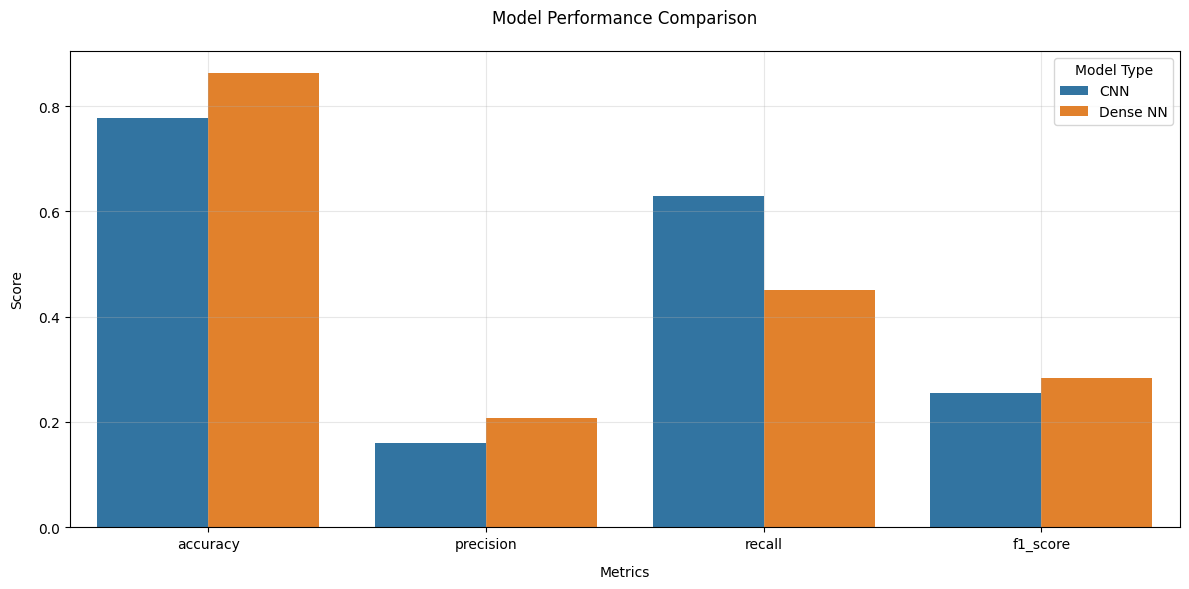


Summary Comparison Table:
   Metric      CNN  Dense NN
 Accuracy 0.776908  0.862035
Precision 0.159836  0.207407
   Recall 0.629032  0.451613
 F1 Score 0.254902  0.284264


In [10]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

df = pd.read_csv("/content/drive/My Drive/CS_4824/healthcare-dataset-stroke-data.csv")

df['bmi'].fillna(df['bmi'].mean(), inplace=True)
df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)

label_encoders = {}
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print("\nDataset Information:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

config = {
    'num_epochs': 400,
    'learning_rate': 0.01,
    'batch_size': 32,
    'dropout_rate': 0.3,
    'hidden_sizes': [128, 64, 32],
    'conv_channels': [16, 32],
    'kernel_size': 3
}

input_size = X_train.shape[1]
num_classes = 2

print("\nTraining CNN Model")
cnn_model = CNN(input_size, num_classes)

start_time_cnn = time.time()
cnn_metrics = train_evaluate_model(cnn_model, X_train_tensor, y_train_tensor,
                                 X_test_tensor, y_test_tensor, config)
end_time_cnn = time.time()
print(f"CNN Training Time: {end_time_cnn - start_time_cnn:.2f} seconds")

print("\nTraining Dense Neural Network")
dense_model = DenseNN(input_size, num_classes)
start_time_dnn = time.time()
dense_metrics = train_evaluate_model(dense_model, X_train_tensor, y_train_tensor,
                                   X_test_tensor, y_test_tensor, config)
end_time_dnn = time.time()
print(f"Dense Neural Network Training Time: {end_time_dnn - start_time_dnn:.2f} seconds")

def print_model_results(model_name, metrics):
    print(f"\n{model_name} Final Results:")
    print("-" * 40)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(np.array(metrics['final_confusion_matrix']))

print_model_results("CNN", cnn_metrics)
print_model_results("Dense Neural Network", dense_metrics)

def plot_detailed_comparison(cnn_metrics, dense_metrics, base_dir='model_outputs'):
    comparison_dir = Path(base_dir) / 'model_comparison'
    comparison_dir.mkdir(parents=True, exist_ok=True)

    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    comparison_data = pd.DataFrame({
        'Metric': metrics * 2,
        'Model': ['CNN'] * len(metrics) + ['Dense NN'] * len(metrics),
        'Score': [cnn_metrics[m] for m in metrics] + [dense_metrics[m] for m in metrics]
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_data)
    plt.title('Model Performance Comparison', pad=20)
    plt.xlabel('Metrics', labelpad=10)
    plt.ylabel('Score', labelpad=10)
    plt.legend(title='Model Type')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(comparison_dir / 'detailed_comparison.png')
    plt.show()

    comparison_results = {
        'CNN': {metric: cnn_metrics[metric] for metric in metrics},
        'Dense NN': {metric: dense_metrics[metric] for metric in metrics}
    }

    with open(comparison_dir / 'detailed_comparison.json', 'w') as f:
        json.dump(comparison_results, f, indent=4)

plot_detailed_comparison(cnn_metrics, dense_metrics)

summary_data = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'CNN': [cnn_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']],
    'Dense NN': [dense_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']]
})

print("\nSummary Comparison Table:")
print(summary_data.to_string(index=False))